In [76]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import plotly
import plotly.graph_objs as go
import scipy.stats as stats

In [77]:
#read super Covid-19 dataframe with state as index. 
USCovid = pd.read_csv("../../../data/output/covid.csv", index_col=0)

### Clean Data

#### Drop unnecessary data

In [78]:
# Clean
USCovid.drop(["Unnamed: 0", "countyFIPS", "stateFIPS"],
             axis=1,
             errors='ignore',
             inplace=True)
USCovid.drop(
    USCovid.loc[USCovid['County Name'] == ("Statewide Unallocated" or 'New York City Unallocated')].index,
    inplace=True)
regex_cases = '(^[0-9]+[/]+[0-9]+[/]+[0-9]+[_]+[x])|^County Name$|^State$|^population$'
regex_deaths = '(^[0-9]+[/]+[0-9]+[/]+[0-9]+[_]+[y])|^County Name$|^State$|^population$'
USCases = USCovid.filter(regex=regex_cases)
USDeaths = USCovid.filter(regex=regex_deaths)

#### Find new cases

In [79]:
def diff(df):
    new = [df[0], df[1], df[2], df[3]]
    for i in range(4, df.shape[0]):
        new.append(df[i] - df[i - 1])
    return pd.Series(new)

In [80]:
columns_D = USDeaths.columns
columns_C = USCases.columns
USNew_Deaths = USDeaths.reset_index(drop=True).T.apply(diff).T
USNew_Deaths.columns = columns_D
USNew_Cases = USCases.reset_index(drop=True).T.apply(diff).T
USNew_Cases.columns = columns_C

In [81]:
USNew_Cases

,County Name,State,population,1/22/20_x,1/23/20_x,1/24/20_x,1/25/20_x,1/26/20_x,1/27/20_x,1/28/20_x,...,10/7/20_x,10/8/20_x,10/9/20_x,10/10/20_x,10/11/20_x,10/12/20_x,10/13/20_x,10/14/20_x,10/15/20_x,10/16/20_x
0,Autauga County,AL,55869,0,0,0,0,0,0,0,...,13,11,19,16,7,6,13,4,21,17
1,Baldwin County,AL,223234,0,0,0,0,0,0,0,...,18,7,31,18,13,17,28,22,15,48
2,Barbour County,AL,24686,0,0,0,0,0,0,0,...,4,0,12,3,0,2,6,0,15,3
3,Bibb County,AL,22394,0,0,0,0,0,0,0,...,12,5,11,7,10,2,6,0,17,10
4,Blount County,AL,57826,0,0,0,0,0,0,0,...,8,8,8,15,9,9,20,8,18,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3140,Sweetwater County,WY,42343,0,0,0,0,0,0,0,...,7,4,11,1,0,0,7,1,4,4
3141,Teton County,WY,23464,0,0,0,0,0,0,0,...,4,12,11,2,4,13,4,7,1,5
3142,Uinta County,WY,20226,0,0,0,0,0,0,0,...,0,5,5,1,1,1,3,1,3,4
3143,Washakie County,WY,7805,0,0,0,0,0,0,0,...,0,4,0,1,1,1,1,5,0,1


In [82]:
# County_State_Pop_columns = USDeaths[USDeaths.columns[0:3]]
# County_State_Pop_columns = USDeaths[USDeaths.columns[0:3]]

# USNew_Deaths = County_State_Pop_columns.merge(USDeaths[USDeaths.columns[3:]].diff(axis=1).fillna(0), left_index =True, right_index=True)
# USNew_Cases = County_State_Pop_columns.merge(USCases[USCases.columns[3:]].diff(axis=1).fillna(0), left_index =True, right_index=True)

#### Convert date type from String to datetime Timestamp

In [83]:
# fixing date string syntax
USNew_Deaths = USNew_Deaths.rename(
    columns=lambda x: (pd.to_datetime((x.split('_')[0]), errors='ignore')),
    errors='raise')


USNew_Cases = USNew_Cases.rename(
    columns=lambda x: (pd.to_datetime((x.split('_')[0]), errors='ignore')),
    errors='raise')

In [84]:
USDeaths_byStates = USNew_Deaths.groupby('State').sum()
USCases_byStates = USNew_Cases.groupby('State').sum()

In [85]:
# Split States and population from the data (temparary)
USDeaths_byStates_SP = USDeaths_byStates.reset_index()[['State', 'population']]
USDeaths_byStates_Date = USDeaths_byStates.reset_index().drop(
    ['County Name', 'State', 'population'], axis=1)

USCases_byStates_SP = USCases_byStates.reset_index()[['State', 'population']]
USCases_byStates_Date = USCases_byStates.reset_index().drop(
    ['County Name', 'State', 'population'], axis=1)

##### Resample date from days to weeks and find the mean of week

In [86]:
USDeaths_byStates_Date.head()

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-10-07,2020-10-08,2020-10-09,2020-10-10,2020-10-11,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16
0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,3,1,3
1,0,0,0,0,0,0,0,0,0,0,...,21,35,16,12,0,1,0,41,50,30
2,0,0,0,0,0,0,0,0,0,0,...,12,22,26,23,16,18,25,23,12,21
3,0,0,0,0,0,0,0,0,0,0,...,21,8,5,11,0,2,8,5,17,17
4,0,0,0,0,0,0,0,0,0,0,...,88,74,74,64,8,25,66,95,79,76


In [109]:
norm_val = 10_000_000

x = USDeaths_byStates_Date.astype(float).divide(USDeaths_byStates_SP['population'], axis=0)
USDeaths_byStates_Date_norm = x.multiply(norm_val)

y = USCases_byStates_Date.astype(float).divide(USCases_byStates_SP['population'], axis=0)
USCases_byStates_Date_norm = y.multiply(norm_val)

In [110]:
# Convert String to TimeStamp
USDeaths_byStates_Date_norm = USDeaths_byStates_Date_norm.rename(
    columns=lambda x: (pd.to_datetime(x, errors='ignore')),
    errors='raise')

USCases_byStates_Date_norm = USCases_byStates_Date_norm.rename(
    columns=lambda x: (pd.to_datetime(x, errors='ignore')),
    errors='raise')

In [111]:
USCases_byStates_Date_norm.head()

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-10-07,2020-10-08,2020-10-09,2020-10-10,2020-10-11,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,1763.391179,1736.051781,2419.536734,3390.085367,3499.442960,2610.912521,2064.124558,1954.766966,2077.794257,3089.351988
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,1915.081727,1142.114768,3036.801589,2163.899588,1666.263867,1496.986143,2267.913611,1605.079148,2418.835920,2473.902168
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,2478.623529,4287.886158,3880.305016,2906.086678,1898.731661,2110.806401,2283.117128,3399.823183,4632.507611,3121.475086
3,0.0,0.0,0.0,0.0,1.373868,0.000000,0.0,0.000000,0.0,0.0,...,833.938179,1184.274646,939.726053,1217.247490,831.190442,652.587537,935.604448,1241.977123,1526.367902,1016.662689
4,0.0,0.0,0.0,0.0,0.506172,0.253086,0.0,0.253086,0.0,0.0,...,905.289485,934.900575,979.190667,681.561248,561.345283,768.369828,1132.307843,874.666050,768.369828,789.375986


In [112]:
USDeaths_byStates_Date_weeks_norm = USDeaths_byStates_Date_norm.resample('W', axis=1).mean().round()
USCases_byStates_Date_weeks_norm = USCases_byStates_Date_norm.resample('W', axis=1).mean().round()

In [113]:
USDeaths_States_weeks_norm = pd.merge(USDeaths_byStates_SP, USDeaths_byStates_Date_weeks_norm, left_index=True, right_index=True)
USCases_States_weeks_norm = pd.merge(USCases_byStates_SP, USCases_byStates_Date_weeks_norm, left_index=True, right_index=True)

#### Find Means, Meidan and Mode for the weeks

In [114]:
# Deaths
USDeaths_means_norm = USDeaths_byStates_Date_weeks_norm.T.mean().round()
USDeaths_median_norm = USDeaths_byStates_Date_weeks_norm.T.median().round()
USDeaths_mode_norm = USDeaths_byStates_Date_weeks_norm.T.mode().round()
USDeaths_mode_norm = USDeaths_mode_norm.values.tolist()
USDeaths_list = [
     USDeaths_byStates_SP['State'], USDeaths_means_norm, USDeaths_median_norm, pd.Series(USDeaths_mode_norm[0])
]

USDeaths_results_norm = pd.DataFrame(USDeaths_list).transpose()
USDeaths_results_norm.columns = ['State', 'Mean', 'Median', 'Mode']

# Cases
USCases_means_norm = USCases_byStates_Date_weeks_norm.T.mean().round()
USCases_median_norm = USCases_byStates_Date_weeks_norm.T.median().round()
USCases_mode_norm = USCases_byStates_Date_weeks_norm.T.mode().round()
USCases_mode_norm = USCases_mode_norm.values.tolist()
USCases_list = [
     USCases_byStates_SP['State'], USCases_means_norm, USCases_median_norm, pd.Series(USCases_mode_norm[0])
]

USCases_results_norm = pd.DataFrame(USCases_list).transpose()
USCases_results_norm.columns = ['State', 'Mean', 'Median', 'Mode']

#### Plot data

In [115]:
trace0 = go.Scatter(x=USCases_results_norm['State'], y=USCases_results_norm['Mean'], 
                    name="Mean", 
                    mode="lines+markers") 
trace1 = go.Scatter(x=USCases_results_norm['State'], y=USCases_results_norm['Median'], 
                    name="Median", 
                    mode="lines+markers") 
trace2 = go.Scatter(x=USCases_results_norm['State'], y=USCases_results_norm['Mode'], 
                    name="Mode", 
                    mode="lines+markers") 
mydata = [trace0, trace1, trace2]

mylayout = go.Layout(
    title="States Weekly Cases"
)

fig = go.Figure(data=mydata, layout=mylayout)

plotly.offline.iplot(fig, filename = '')

In [116]:
trace0 = go.Scatter(x=USDeaths_results_norm['State'], y=USDeaths_results_norm['Mean'], 
                    name="Mean", 
                    mode="lines+markers") 
trace1 = go.Scatter(x=USDeaths_results_norm['State'], y=USDeaths_results_norm['Median'], 
                    name="Median", 
                    mode="lines+markers") 
trace2 = go.Scatter(x=USDeaths_results_norm['State'], y=USDeaths_results_norm['Mode'], 
                    name="Mode", 
                    mode="lines+markers") 
mydata = [trace0, trace1, trace2]

mylayout = go.Layout(
    title="States Weekly Deaths"
)

fig = go.Figure(data=mydata, layout=mylayout)

plotly.offline.iplot(fig, filename = '')

####  

#### Counites

In [117]:
FL_NewDeaths = USNew_Deaths[USNew_Deaths['State'] == 'FL']
FL_NewCases = USNew_Cases[USNew_Cases['State'] == 'FL']

zer = FL_NewCases[FL_NewCases.population != 0]
FL_NewCases_SP = zer.reset_index()[['County Name','State', 'population']]
FL_NewCases_Date = zer.reset_index().drop(
    ['County Name', 'State', 'population', 'index'], axis=1)
FL_NewCases_Date

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-10-07,2020-10-08,2020-10-09,2020-10-10,2020-10-11,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16
0,0,0,0,0,0,0,0,0,0,0,...,23,91,84,0,114,54,70,78,57,117
1,0,0,0,0,0,0,0,0,0,0,...,22,35,13,0,16,2,3,17,13,17
2,0,0,0,0,0,0,0,0,0,0,...,12,22,19,0,33,2,44,19,28,14
3,0,0,0,0,0,0,0,0,0,0,...,4,6,3,0,9,2,4,6,7,3
4,0,0,0,0,0,0,0,0,0,0,...,57,89,120,0,136,23,89,85,73,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0,0,0,0,0,0,0,0,0,0,...,8,3,4,0,13,0,8,4,17,8
63,0,0,0,0,0,0,0,0,0,0,...,45,90,53,0,115,39,50,67,90,80
64,0,0,0,0,0,0,0,0,0,0,...,4,9,2,0,15,5,1,8,10,14
65,0,0,0,0,0,0,0,0,0,0,...,13,11,27,0,29,3,10,28,23,17


In [120]:
norm_val = 10_000
x = FL_NewCases_Date.divide(FL_NewCases_SP['population'], axis=0)
USDeaths_byStates_Date_norm = x.multiply(norm_val)

y = USCases_byStates_Date.astype(float).divide(USCases_byStates_SP['population'], axis=0)
FL_NewCases_Date_norm = y.multiply(norm_val)

In [121]:

_NewCases = FL_NewCases_SP.merge(pd.DataFrame(FL_NewCases_Date_norm.sum(axis=1)), left_index=True, right_index=True)
_NewCases.head()

,County Name,State,population,0
0,Alachua County,FL,269043,144.174316
1,Baker County,FL,29210,347.476181
2,Bay County,FL,174705,316.644156
3,Bradford County,FL,28201,315.283586
4,Brevard County,FL,601942,220.564153


In [122]:
# find the top 5 counites
FL_NewCases_top5 = FL_NewCases_SP.merge(pd.DataFrame(FL_NewCases_Date_norm.sum(axis=1)), left_index=True, right_index=True)
FL_NewCases_top5.rename(columns={0: 'Normalized Cases'}, inplace=True)


In [123]:
FL_NewCases_top5 = FL_NewCases_top5.nlargest(5, ['Normalized Cases'])
FL_NewCases_top5.head()

,County Name,State,population,Normalized Cases
28,Holmes County,FL,19617,400.452982
18,Gadsden County,FL,45660,375.142456
25,Hernando County,FL,193920,367.101916
41,Martin County,FL,161000,359.517057
9,Clay County,FL,219252,347.564085


In [124]:
FL_NewCases_top5_daily = FL_NewCases_SP.merge(FL_NewCases_Date_norm, left_index=True, right_index=True)

FL_NewCases_top5_daily =FL_NewCases[FL_NewCases['County Name'].isin(['Holmes County', 'Gadsden County', 'Hernando County', 'Martin County', 'Clay County'])]
FL_NewCases_top5_daily.head()

,County Name,State,population,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,...,2020-10-07 00:00:00,2020-10-08 00:00:00,2020-10-09 00:00:00,2020-10-10 00:00:00,2020-10-11 00:00:00,2020-10-12 00:00:00,2020-10-13 00:00:00,2020-10-14 00:00:00,2020-10-15 00:00:00,2020-10-16 00:00:00
331,Clay County,FL,219252,0,0,0,0,0,0,0,...,22,32,24,0,77,19,32,21,40,31
340,Gadsden County,FL,45660,0,0,0,0,0,0,0,...,8,19,13,0,26,5,7,1,13,10
347,Hernando County,FL,193920,0,0,0,0,0,0,0,...,18,14,20,0,13,0,0,0,35,26
350,Holmes County,FL,19617,0,0,0,0,0,0,0,...,3,7,3,0,6,3,6,4,9,6
363,Martin County,FL,161000,0,0,0,0,0,0,0,...,12,19,20,0,22,1,16,13,13,22


In [125]:
Martin = FL_NewCases_top5_daily[(FL_NewCases_top5_daily['County Name'] == 'Martin County')][FL_NewCases_top5_daily.columns[3:]].T
Clay = FL_NewCases_top5_daily[(FL_NewCases_top5_daily['County Name'] == 'Clay County')][FL_NewCases_top5_daily.columns[3:]].T
Gadsden = FL_NewCases_top5_daily[(FL_NewCases_top5_daily['County Name'] == 'Gadsden County')][FL_NewCases_top5_daily.columns[3:]].T
Hernando =FL_NewCases_top5_daily[(FL_NewCases_top5_daily['County Name'] == 'Hernando County')][FL_NewCases_top5_daily.columns[3:]].T
Holmes = FL_NewCases_top5_daily[(FL_NewCases_top5_daily['County Name'] == 'Holmes County')][FL_NewCases_top5_daily.columns[3:]].T


In [126]:
trace0 = go.Scatter(x=Martin.index, y=Martin.iloc[:,0], 
                    name="Martin", 
                    mode="lines+markers") 
trace1 = go.Scatter(x=Holmes.index, y=Holmes.iloc[:,0], 
                    name="Holmes", 
                    mode="lines+markers") 
trace2 = go.Scatter(x=Hernando.index, y=Hernando.iloc[:,0], 
                    name="Hernando", 
                    mode="lines+markers") 
trace3 = go.Scatter(x=Gadsden.index, y=Gadsden.iloc[:,0], 
                    name="Gadsden", 
                    mode="lines+markers") 
trace4 = go.Scatter(x=Clay.index, y=Clay.iloc[:,0], 
                    name="Clay", 
                    mode="lines+markers") 

mydata = [trace0, trace1, trace2, trace3, trace4]

mylayout = go.Layout(
    title="Top 5 counites daily cases"
)

fig = go.Figure(data=mydata, layout=mylayout)

plotly.offline.iplot(fig, filename = '')

### Task 2

Fit a distribution to the number of COVID-19 cases of a state.
- Graphically plot the distribution and describe the distribution statistics.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CEBF82AE50>]],
      dtype=object)

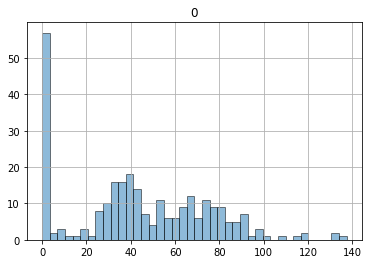

In [152]:
FLState_NewCases_Date= FL_NewCases_Date_norm.sum(axis=0)
pd.DataFrame(FLState_NewCases_Date).hist(bins=40, alpha=0.5,  ec='black')

The graph show that most of the cases in state of Florida by daily cases is round 0 cases. Also, from abserving the graph the result indecate that the disterbution is skewed left. 

- Describe why the distribution was choosen and its statistics in the report and the notebook.

I choose to distribute daily cases. 

Model a poission distribution of COVID-19 cases and deaths of a state and compare to other 5 states. Number of new cases and deaths per 1000 populations. (normalize by population)

In [175]:
norm_val = 1_000

x = USDeaths_byStates_Date.astype(float).divide(USDeaths_byStates_SP['population'], axis=0)
USDeaths_States_Date_norm_10 = x.multiply(norm_val)

y = USCases_byStates_Date.astype(float).divide(USCases_byStates_SP['population'], axis=0)
USCases_States_Date_norm_10 = y.multiply(norm_val)

In [176]:
# Convert String to TimeStamp
USDeaths_States_Date_norm_10 = USDeaths_States_Date_norm_10.rename(
    columns=lambda x: (pd.to_datetime(x, errors='ignore')),
    errors='raise')

USCases_States_Date_norm_10 = USCases_States_Date_norm_10.rename(
    columns=lambda x: (pd.to_datetime(x, errors='ignore')),
    errors='raise')

In [177]:
USDeaths_States_Date_weeks_norm_10 = USDeaths_States_Date_norm_10.resample('W', axis=1).mean().round()
USCases_States_Date_weeks_norm_10 = USCases_States_Date_norm_10.resample('W', axis=1).mean().round()

In [178]:
USDeaths_States_weeks_norm_10 = pd.merge(USDeaths_byStates_SP, USDeaths_States_Date_weeks_norm_10, left_index=True, right_index=True)
USCases_States_weeks_norm_10 = pd.merge(USCases_byStates_SP, USCases_States_Date_weeks_norm_10, left_index=True, right_index=True)

In [179]:
USCases_States_weeks_norm_10.head()

,State,population,2020-01-26 00:00:00,2020-02-02 00:00:00,2020-02-09 00:00:00,2020-02-16 00:00:00,2020-02-23 00:00:00,2020-03-01 00:00:00,2020-03-08 00:00:00,2020-03-15 00:00:00,...,2020-08-16 00:00:00,2020-08-23 00:00:00,2020-08-30 00:00:00,2020-09-06 00:00:00,2020-09-13 00:00:00,2020-09-20 00:00:00,2020-09-27 00:00:00,2020-10-04 00:00:00,2020-10-11 00:00:00,2020-10-18 00:00:00
0,AK,731545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AL,4903185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AR,3017804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AZ,7278717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CA,39512223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [188]:
FL = USCases_States_weeks_norm_10.loc[USCases_States_weeks_norm_10['State'] == 'FL'].iloc[0]
NC = USCases_States_weeks_norm_10.loc[USCases_States_weeks_norm_10['State'] == 'NC'].iloc[0]
NY = USCases_States_weeks_norm_10.loc[USCases_States_weeks_norm_10['State'] == 'NY'].iloc[0]
AL = USCases_States_weeks_norm_10.loc[USCases_States_weeks_norm_10['State'] == 'AL'].iloc[0]
FL[2:].mean()

0.02564102564102564

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CEBBC454C0>]],
      dtype=object)

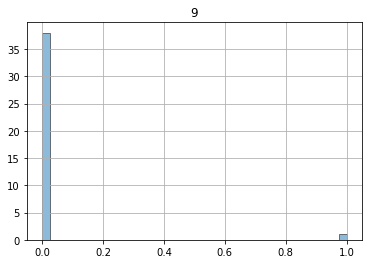

In [191]:
FL_weekly_sum= FL[2:].astype(int)
pd.DataFrame(FL_weekly_sum).hist(bins=40, alpha=0.5,  ec='black')

In [182]:
USDeaths_States_weeks_norm_10.head()

,State,population,2020-01-26 00:00:00,2020-02-02 00:00:00,2020-02-09 00:00:00,2020-02-16 00:00:00,2020-02-23 00:00:00,2020-03-01 00:00:00,2020-03-08 00:00:00,2020-03-15 00:00:00,...,2020-08-16 00:00:00,2020-08-23 00:00:00,2020-08-30 00:00:00,2020-09-06 00:00:00,2020-09-13 00:00:00,2020-09-20 00:00:00,2020-09-27 00:00:00,2020-10-04 00:00:00,2020-10-11 00:00:00,2020-10-18 00:00:00
0,AK,731545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AL,4903185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AR,3017804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AZ,7278717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CA,39512223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
rate_1 = stats.poisson.pmf(k=FL_mean, mu=FL_mean)

rate_1

0.0111370079420705

Model poission distributions for North Carolina counties COVID-19 in cases and deaths. Number of new cases and deaths per 1000 populations.

Perform corelation between Enrichment data valiables and COVID-19 cases to observe any patterns.

Formulate hypothesis between Enrichment data and number of cases to be compared against states. Choose 3 different variables to compare against.
- For example: Does higher employment data lead to higher covid case numbers or more rapid increase in covid cases.
